# Manual Preprocessing

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


In [3]:
df_train = pd.read_csv("../our data/no_outliers.csv")
df_test = pd.read_csv("../data/obesity_test.csv")

df_test = df_test.drop(columns=["region", "marrital_status"])

# Scale and KNN-impute data
scalers = {} # Preserve scalers for antitransformation

columns = ['age', 'height', 'weight']
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5, weights='uniform')

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])


# Impute
df_train[columns] = imputer.fit_transform(df_train[columns])
df_test[columns] = imputer.transform(df_test[columns])

# Transform back 
df_train[columns] = scaler.inverse_transform(df_train[columns])
df_test[columns] = scaler.inverse_transform(df_test[columns])
    


In [4]:
def classify_bmi_comprehensive(row):
    """
    Classify BMI based on age and BMI value.

    Input:
    row: A Pandas row with 'weight', 'height', and 'age' columns.

    Output:
    Returns a string that classifies the individual into BMI categories.
    """
    # Check if weight and height are valid
    if row['height'] <= 0 or row['weight'] <= 0:
        return 'Invalid data'

    # Calculate BMI
    bmi = row['weight'] / (row['height'] ** 2)

    # Age group: Children (2-19 years)
    if 2 <= row['age'] < 20:
        if bmi < 14:
            return 0 # Underweight
        elif 14 <= bmi < 18:
            return 1 # Normal weight
        elif 18 <= bmi < 21:
            return 2 # Overweight
        else:
            return 3 # Obesity 1

    # Age group: Adults (20-64 years)
    elif 20 <= row['age'] < 65:
        if bmi < 18.5:
            return 0 # "Underweight"
        elif 18.5 <= bmi < 25:
            return 1 # "Healthy Weight"
        elif 25 <= bmi < 30:
            return 2 #"Overweight"
        elif 30<= bmi < 35:
            return 3 #"Obese Class 1"
        elif 35 <= bmi < 40:
            return 4 #"Obese Class 2"
        else:
            return 5 #"Obese Class 3"

In [5]:
# Add BMI
df_train['bmi_class'] = df_train.apply(lambda row: classify_bmi_comprehensive(row), axis=1)
df_test['bmi_class'] = df_test.apply(lambda row: classify_bmi_comprehensive(row), axis=1)

In [6]:
# Fill missing activity with zero
df_train['physical_activity_perweek'].fillna('No Activity')
df_test['physical_activity_perweek'].fillna('No Activity')


0        5 or more
1      No Activity
2           1 to 2
3           1 to 2
4           3 to 4
          ...     
495    No Activity
496    No Activity
497    No Activity
498    No Activity
499         3 to 4
Name: physical_activity_perweek, Length: 500, dtype: object

In [7]:
hashmap = {
"Never": 0,
"Sometimes": 1,
"Frequently": 2,
"Always": 3,

"No Activity": 0,
"up to 2": 1,
"up to 5": 2,
"more than 5": 3,

"less than 1": 1,
"1 to 2": 2,
"more than 2": 3,
"3 to 4": 4,
"5 or more": 5,

"Bicycle": 1,
"Car": 3,
"Motorbike": 3,
"Public": 2,
"Walk": 0,

"no": 0,
"yes": 1,

"Male": 0,
"Female": 1
}


In [8]:
# Manually encode data

columns = ['alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'gender',
 'monitor_calories',
 'parent_overweight',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily',
 'bmi_class',
 'meals_perday',
 "siblings"]

for target in columns:
    df_train[target] = df_train[target].replace(hashmap)
    df_test[target]= df_test[target].replace(hashmap)


In [9]:
# Fill rest with KNN or smt else

# Scale numerical (again) and KNN-impute data

#columnsx = ['age', 'height', 'weight']
#scaler = StandardScaler()
imputer = DecisionTreeClassifier()
imputer = IterativeImputer(imputer)

#df_train[columnsx] = scaler.fit_transform(df_train[columnsx])
#df_test[columnsx] = scaler.transform(df_test[columnsx])

df_train[columns] = imputer.fit_transform(df_train[columns])
df_test[columns] = imputer.transform(df_test[columns])

In [10]:
# Transform to life score
life_columns = [
 'alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'monitor_calories',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily',
]

bad_columns = [
 'eat_between_meals',
 'alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'smoke',
 'transportation',
]

good_columns = [
 'monitor_calories',
 'physical_activity_perweek',
 'veggies_freq',
 'water_daily',
]

df_train["life"] = 0
df_test["life"] = 0

for column in good_columns:
    df_train["life"] += df_train[column]
    df_test["life"] += df_test[column]


for column in bad_columns:
    df_train["life"] -= df_train[column]
    df_test["life"] -= df_test[column]




In [11]:
hash_obesity = {
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
 'Obesity_Type_I': 4,
 'Insufficient_Weight': 5,
 'Obesity_Type_II': 6,
 'Obesity_Type_III': 7
 }

X = df_train.iloc[:, 1:].drop(columns='obese_level')
y = df_train['obese_level'].replace(hash_obesity)



In [12]:
# Define general function to preprocess data without information leak
def classify_bmi_comprehensive(row):
    """
    Classify BMI based on age and BMI value.

    Input:
    row: A Pandas row with 'weight', 'height', and 'age' columns.

    Output:
    Returns a string that classifies the individual into BMI categories.
    """
    # Check if weight and height are valid
    if row['height'] <= 0 or row['weight'] <= 0:
        return 'Invalid data'

    # Calculate BMI
    bmi = row['weight'] / (row['height'] ** 2)

    # Age group: Children (2-19 years)
    if 2 <= row['age'] < 20:
        if bmi < 14:
            return 0 # Underweight
        elif 14 <= bmi < 18:
            return 1 # Normal weight
        elif 18 <= bmi < 21:
            return 2 # Overweight
        else:
            return 3 # Obesity 1

    # Age group: Adults (20-64 years)
    elif 20 <= row['age'] < 65:
        if bmi < 18.5:
            return 0 # "Underweight"
        elif 18.5 <= bmi < 25:
            return 1 # "Healthy Weight"
        elif 25 <= bmi < 30:
            return 2 #"Overweight"
        elif 30<= bmi < 35:
            return 3 #"Obese Class 1"
        elif 35 <= bmi < 40:
            return 4 #"Obese Class 2"
        else:
            return 5 #"Obese Class 3"
        
def preprocess_data(X_train, X_test):
    df_train = X_train.copy()
    df_test = X_test.copy()
    # START
    # 1. Scale and KNN-impute data
    columns = ['age', 'height', 'weight']
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=5, weights='uniform')

    df_train[columns] = scaler.fit_transform(df_train[columns])
    df_test[columns] = scaler.transform(df_test[columns])


    # Impute
    df_train[columns] = imputer.fit_transform(df_train[columns])
    df_test[columns] = imputer.transform(df_test[columns])

    # Transform back 
    df_train[columns] = scaler.inverse_transform(df_train[columns])
    df_test[columns] = scaler.inverse_transform(df_test[columns])

    # Add BMI 
    df_train['bmi_class'] = df_train.apply(lambda row: classify_bmi_comprehensive(row), axis=1)
    df_test['bmi_class'] = df_test.apply(lambda row: classify_bmi_comprehensive(row), axis=1)

    # Fill missing activity with 0
    df_train['physical_activity_perweek'].fillna('No Activity')
    df_test['physical_activity_perweek'].fillna('No Activity')

    # Encode categoricals with hashmap (my favourite)
    hashmap = {
        "Never": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3,

        "No Activity": 0,
        "up to 2": 1,
        "up to 5": 2,
        "more than 5": 3,

        "less than 1": 1,
        "1 to 2": 2,
        "more than 2": 3,
        "3 to 4": 4,
        "5 or more": 5,

        "Bicycle": 1,
        "Car": 4,
        "Motorbike": 3,
        "Public": 2,
        "Walk": 0,

        "no": 0,
        "yes": 1,

        "Male": 0,
        "Female": 1
        }

    columns = ['alcohol_freq',
    'caloric_freq',
    'devices_perday',
    'eat_between_meals',
    'gender',
    'monitor_calories',
    'parent_overweight',
    'physical_activity_perweek',
    'smoke',
    'transportation',
    'veggies_freq',
    'water_daily',
    'bmi_class',
    'meals_perday',
    "siblings"]

    for target in columns:
        df_train[target] = df_train[target].replace(hashmap)
        df_test[target]= df_test[target].replace(hashmap)


    # Fill the ordinal variables with iterative Random Forests
    imputer = DecisionTreeClassifier()
    imputer = IterativeImputer(imputer)

    df_train[columns] = imputer.fit_transform(df_train[columns])
    df_test[columns] = imputer.transform(df_test[columns])

    # Transform to life score
    life_columns = [
    'alcohol_freq',
    'caloric_freq',
    'devices_perday',
    'eat_between_meals',
    'monitor_calories',
    'physical_activity_perweek',
    'smoke',
    'transportation',
    'veggies_freq',
    'water_daily',
    ]

    df_train["life"] = 0
    df_test["life"] = 0

    for column in life_columns:
        df_train["life"] += df_train[column]
        df_test["life"] += df_test[column]

    return df_train, df_test

# Feature selection with wrapper method

In [13]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [14]:
df = pd.read_csv("../our data/no_outliers.csv", index_col=0)

X = df.drop('obese_level', axis=1)
y = df['obese_level']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train, X_test = preprocess_data(X_train, X_test)

In [16]:
baseline = DecisionTreeClassifier()
k = 5 # suppose i want to select 5

rfe = RFE(estimator=baseline, n_features_to_select=k)
rfe.fit_transform(X_train, y_train)

selected_features = pd.Series(rfe.support_, index = X_train.columns)
selected_features


rfe.score(X_test, y_test)

0.893970893970894

In [17]:
# same as above but iterate k
max_score = -999 
info = {}

for i in range(1, len(X_train.columns.tolist())+1):
    rfe = RFE(estimator=baseline, n_features_to_select=i)
    rfe.fit_transform(X_train, y_train)
    s = rfe.score(X_test, y_test)
    print(f"k={i}: {s}")
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    S=selected_features[selected_features == True].index.tolist()
    print(f"\tSelected: {S}")

    if s>max_score:
        max_score = s
        info['i'] = i
        info['selected'] = S

print("=========================*2")
print(info)


k=1: 0.6195426195426196
	Selected: ['bmi_class']
k=2: 0.7941787941787942
	Selected: ['weight', 'bmi_class']
k=3: 0.7962577962577962
	Selected: ['gender', 'weight', 'bmi_class']
k=4: 0.8752598752598753
	Selected: ['age', 'gender', 'weight', 'bmi_class']
k=5: 0.896049896049896
	Selected: ['age', 'gender', 'height', 'weight', 'bmi_class']
k=6: 0.8794178794178794
	Selected: ['age', 'caloric_freq', 'gender', 'height', 'weight', 'bmi_class']
k=7: 0.8752598752598753
	Selected: ['age', 'caloric_freq', 'gender', 'height', 'weight', 'bmi_class', 'life']
k=8: 0.8856548856548857
	Selected: ['age', 'caloric_freq', 'gender', 'height', 'meals_perday', 'weight', 'bmi_class', 'life']
k=9: 0.8794178794178794
	Selected: ['age', 'caloric_freq', 'gender', 'height', 'meals_perday', 'water_daily', 'weight', 'bmi_class', 'life']
k=10: 0.8814968814968815
	Selected: ['age', 'caloric_freq', 'eat_between_meals', 'gender', 'height', 'meals_perday', 'water_daily', 'weight', 'bmi_class', 'life']
k=11: 0.875259875259

# Statistical tests for correlation

In [18]:
df_train

,Unnamed: 0,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,...,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level,bmi_class,life
0,0,21.0,0.0,0.0,2.0,1.0,1.0,1.62,3.0,0.0,...,2.0,3.0,0.0,2.0,1.0,2.0,64.0,Normal_Weight,1.0,0.0
1,1,23.0,2.0,0.0,2.0,1.0,0.0,1.80,3.0,0.0,...,4.0,0.0,0.0,2.0,1.0,2.0,77.0,Normal_Weight,1.0,0.0
2,2,20.6,2.0,0.0,1.0,1.0,0.0,1.80,3.0,0.0,...,4.0,2.0,0.0,0.0,3.0,2.0,87.0,Overweight_Level_I,2.0,5.0
3,3,22.0,1.0,0.0,1.0,1.0,0.0,1.78,1.0,0.0,...,4.0,3.0,0.0,2.0,1.0,2.0,90.0,Overweight_Level_II,2.0,2.0
4,4,22.0,1.0,0.0,1.0,1.0,0.0,1.64,3.0,0.0,...,5.0,3.0,0.0,2.0,1.0,2.0,53.0,Normal_Weight,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,1598,21.0,1.0,1.0,2.0,1.0,1.0,1.73,3.0,0.0,...,4.0,1.0,0.0,2.0,3.0,2.0,131.0,Obesity_Type_III,5.0,2.0
1599,1599,22.0,1.0,1.0,2.0,1.0,1.0,1.75,3.0,0.0,...,2.0,0.0,0.0,2.0,3.0,2.0,134.0,Obesity_Type_III,5.0,0.0
1600,1600,23.0,1.0,1.0,2.0,1.0,1.0,1.75,3.0,0.0,...,2.0,0.0,0.0,2.0,3.0,2.0,134.0,Obesity_Type_III,5.0,0.0
1601,1601,24.0,1.0,1.0,2.0,1.0,1.0,1.74,3.0,0.0,...,2.0,0.0,0.0,2.0,3.0,3.0,133.0,Obesity_Type_III,5.0,1.0


In [19]:
cor = df_train[['age', 'weight', 'height', 'life']].replace({"obese_level": hash_obesity}).corr()
import seaborn as sns

cor.style.highlight_between(left=-1, right=-.69, color="gold").highlight_between(left=.69, right=1, color="gold")

,age,weight,height,life
age,1.000000,0.242086,-0.004945,-0.103273
weight,0.242086,1.000000,0.467835,-0.013192
height,-0.004945,0.467835,1.000000,-0.049377
life,-0.103273,-0.013192,-0.049377,1.000000


In [20]:
cor = df_train.replace({"obese_level": hash_obesity}).iloc[:, 1:].corr(method="spearman")
cor.style.highlight_between(left=-1, right=-.69, color="red").highlight_between(left=.69, right=1, color="red").highlight_between(left=-0.01, right=0.01, color="green")

,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,parent_overweight,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level,bmi_class,life
age,1.000000,0.122346,0.119320,-0.267280,-0.122630,-0.069836,0.025875,-0.065078,-0.167786,0.271117,-0.094569,0.003583,0.079838,0.459331,0.051219,0.018372,0.383939,0.210730,0.276010,-0.082791
alcohol_freq,0.122346,1.000000,0.096263,-0.044800,-0.085632,0.010809,0.122552,0.075306,-0.021438,-0.022959,-0.108068,-0.007046,0.065539,-0.011400,0.078036,0.091113,0.223534,0.137061,0.177197,-0.200875
caloric_freq,0.119320,0.096263,1.000000,0.072587,-0.187466,-0.068346,0.186510,-0.024013,-0.186670,0.222723,-0.083676,-0.019152,-0.031906,0.153425,-0.032271,0.014593,0.286064,0.226958,0.245394,-0.254262
devices_perday,-0.267280,-0.044800,0.072587,1.000000,0.028937,0.026459,0.069581,0.047763,-0.031795,0.032156,0.109251,-0.028487,0.017943,-0.141449,-0.064066,-0.039338,-0.040223,-0.005690,-0.052085,-0.269761
eat_between_meals,-0.122630,-0.085632,-0.187466,0.028937,1.000000,0.128637,-0.085740,0.125098,0.110047,-0.194201,0.056863,0.000746,0.032575,-0.066578,0.074355,-0.178914,-0.301204,-0.130444,-0.300418,-0.111023
gender,-0.069836,0.010809,-0.068346,0.026459,0.128637,1.000000,-0.640966,-0.060280,0.107411,-0.112727,0.017955,-0.019748,-0.062478,-0.126328,0.291765,-0.091767,-0.213913,0.132239,0.022850,0.162039
height,0.025875,0.122552,0.186510,0.069581,-0.085740,-0.640966,1.000000,0.210856,-0.131879,0.251510,0.032882,0.030175,0.068275,0.088092,-0.084158,0.179593,0.469418,0.122214,0.117376,-0.066487
meals_perday,-0.065078,0.075306,-0.024013,0.047763,0.125098,-0.060280,0.210856,1.000000,-0.007534,0.053616,0.102284,0.045205,0.032030,0.037676,0.034473,0.054180,0.047339,0.129001,0.008363,0.035144
monitor_calories,-0.167786,-0.021438,-0.186670,-0.031795,0.110047,0.107411,-0.131879,-0.007534,1.000000,-0.217336,0.029267,-0.019362,0.034510,-0.054242,0.069657,0.003524,-0.215413,-0.147260,-0.140436,0.136951
parent_overweight,0.271117,-0.022959,0.222723,0.032156,-0.194201,-0.112727,0.251510,0.053616,-0.217336,1.000000,-0.101407,0.002009,0.030320,0.140770,-0.000636,0.110322,0.496622,0.259543,0.426606,-0.068662


# Statistical tests (Spearman Rank)

In [21]:
import scipy.stats as stats
from scipy.stats import mannwhitneyu


In [22]:
#note: slightly modify the code
catcol =  ['alcohol_freq',
 'caloric_freq',
 'devices_perday',
 'eat_between_meals',
 'gender',
 'monitor_calories',
 'parent_overweight',
 'physical_activity_perweek',
 'smoke',
 'transportation',
 'veggies_freq',
 'water_daily',
 'bmi_class',
 'meals_perday',
 "siblings"]


import pandas as pd
from scipy.stats import spearmanr

def test_spearman_correlation(X, y, var, alpha=0.05):
    # Calculate Spearman's rank correlation between the predictor and the target
    spearman_corr, p_value = spearmanr(X[var], y)
    
    # Interpret the result based on the p-value
    if p_value < alpha:
        result = f"{var} is IMPORTANT for prediction (Spearman's correlation = {spearman_corr:.2f}, p = {p_value:.4f})"
    else:
        result = f"{var} is NOT an important predictor (Spearman's correlation = {spearman_corr:.2f}, p = {p_value:.4f})"
    
    print(result)

# Example usage
# X is a DataFrame containing predictors, y is a Series containing the target variable, and 'var' is the column name of the predictor to test.
# test_spearman_c

X_p, _ = preprocess_data(X, X_train)
for var in catcol:
    test_spearman_correlation(X_p, y, var)


alcohol_freq is IMPORTANT for prediction (Spearman's correlation = 0.12, p = 0.0000)
caloric_freq is IMPORTANT for prediction (Spearman's correlation = 0.05, p = 0.0432)
devices_perday is NOT an important predictor (Spearman's correlation = -0.04, p = 0.1409)
eat_between_meals is IMPORTANT for prediction (Spearman's correlation = -0.36, p = 0.0000)
gender is NOT an important predictor (Spearman's correlation = -0.01, p = 0.6089)
monitor_calories is IMPORTANT for prediction (Spearman's correlation = -0.08, p = 0.0011)
parent_overweight is IMPORTANT for prediction (Spearman's correlation = 0.31, p = 0.0000)
physical_activity_perweek is IMPORTANT for prediction (Spearman's correlation = -0.15, p = 0.0000)
smoke is NOT an important predictor (Spearman's correlation = -0.03, p = 0.2438)
transportation is IMPORTANT for prediction (Spearman's correlation = 0.05, p = 0.0438)
veggies_freq is NOT an important predictor (Spearman's correlation = 0.02, p = 0.4648)
water_daily is IMPORTANT for pred

# Model testing

In [23]:
# set up rkf

def run(model, X, y):
    my_model = model
    rkf = RepeatedKFold(n_splits=10)

    scores_train = []
    scores_val = []

    i = 0
    for (train_index, test_index) in rkf.split(X, y):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        X_train, X_test = preprocess_data(X_train, X_test)

        my_model.fit(X_train, y_train)

        report1 = classification_report(y_test, y_hat:=my_model.predict(X_test), output_dict=True)
        report2 = classification_report(y_train, y_hat:=my_model.predict(X_train), output_dict=True)

        scores_val.append(report1["macro avg"]["f1-score"])
        scores_train.append(report2["macro avg"]["f1-score"])
        print(i)
        i+=1

    return np.array(scores_train).mean(), np.array(scores_val).mean(), my_model.feature_importances_

        

In [24]:
# run(RandomForestClassifier(), X, y)

In [25]:
A = np. array([0.08684592, 0.02916015, 0.01698479, 0.02002437, 0.02886051,
        0.06605276, 0.08397836, 0.02910226, 0.00474715, 0.0283351 ,
        0.01465299, 0.01462235, 0.00200634, 0.02188073, 0.02701335,
        0.01607257, 0.23612015, 0.23541477, 0.0381254 ])

pd.DataFrame(A, index=X_train.columns, columns=["b"]).sort_values(by="b",ascending=False).style.bar()

,b
weight,0.236120
bmi_class,0.235415
age,0.086846
height,0.083978
gender,0.066053
life,0.038125
alcohol_freq,0.029160
meals_perday,0.029102
eat_between_meals,0.028861
parent_overweight,0.028335


In [27]:
# run(DecisionTreeClassifier(), X, y)

In [28]:
A = np.array([0.10193846, 0.03012724, 0.01176187, 0.00337386, 0.00445542,
        0.1610644 , 0.08341583, 0.01239505, 0.00134955, 0.01086837,
        0.00080973, 0.00495463, 0.        , 0.00766767, 0.00428283,
        0.00735991, 0.19896782, 0.34659038, 0.00861699])


pd.DataFrame(A, index=X_train.columns, columns=["b"]).sort_values(by="b",ascending=False).style.bar()

,b
bmi_class,0.346590
weight,0.198968
gender,0.161064
age,0.101938
height,0.083416
alcohol_freq,0.030127
meals_perday,0.012395
caloric_freq,0.011762
parent_overweight,0.010868
life,0.008617


In [29]:
# run(LogisticRegression(solver="liblinear"), X, y)

In [30]:
# run(LogisticRegression(solver="newton-cg"), X, y)

In [31]:
# run(LogisticRegression(solver="newton-cholesky"), X, y)

In [33]:
#run(GaussianNB(), X, y)

# Model Interpretation

In [34]:
import pandas as pd

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
df_train = pd.read_csv("../our data/no_outliers.csv", index_col=0)
X = df_train.drop('obese_level', axis=1)
y = df['obese_level']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=.70)

X_train, X_test = preprocess_data(X_train, X_test)
# X_train = X_train.drop(columns=["age", "weight", "height"])
# X_test = X_test.drop(columns=["age", "weight", "height"])

rf = GradientBoostingClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [39]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.88      0.92        60
      Normal_Weight       0.82      0.87      0.84        68
     Obesity_Type_I       0.96      0.94      0.95        83
    Obesity_Type_II       0.97      0.96      0.96        67
   Obesity_Type_III       0.98      1.00      0.99        62
 Overweight_Level_I       0.84      0.90      0.87        62
Overweight_Level_II       0.95      0.92      0.94        79

           accuracy                           0.93       481
          macro avg       0.93      0.92      0.92       481
       weighted avg       0.93      0.93      0.93       481



1 Insufficient_Weight
2 Normal_Weight
3 Obesity_Type_I
4 Obesity_Type_II
5 Obesity_Type_III
6 Overweight_Level_I
7 Overweight_Level_II


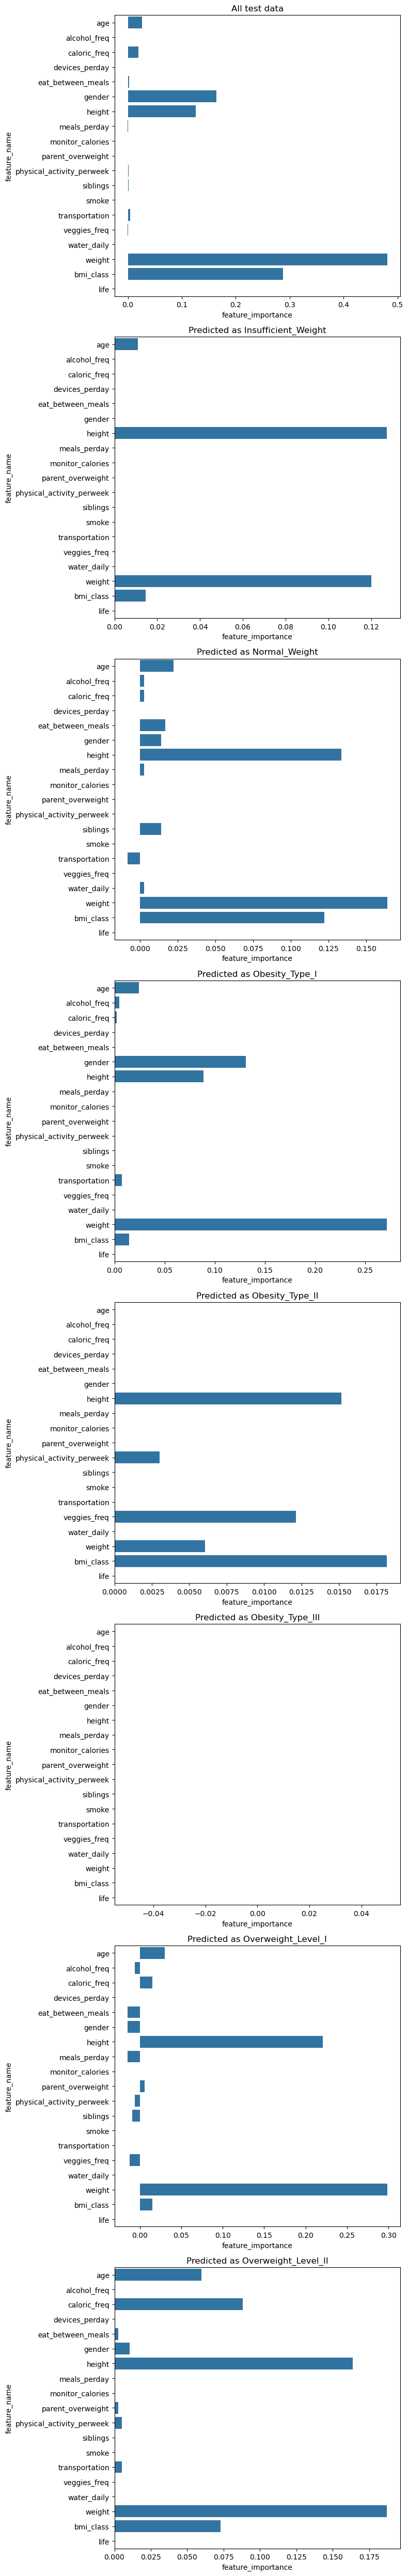

In [41]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_importances(model, x, y, title, ax):
    result = permutation_importance(model, x, y, n_repeats=5)
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': result.importances_mean, 'feature_std': result.importances_std})
    sns.barplot(data=df, x='feature_importance', y='feature_name',errorbar="ci", ci="sd", ax=ax)
    ax.set_title(title)


z = np.unique(y_pred)
fig, axes = plt.subplots(len(z)+1,1, figsize=(8, 50))
plot_feature_importances(rf, X_test, y_test, 'All test data', ax=axes[0])

for i,C in enumerate(z):
    plot_feature_importances(rf, X_test[y_pred == C], y_test[y_pred == C], f'Predicted as {C}', axes[i+1])
    print(i+1, C)

plt.tight_layout()
plt.show()